# Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

### Instalar dependencias

In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Cargado de bibliotecas

In [2]:
# Datos
import numpy as np
import pandas as pd

# Preprocesado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Metricas
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, make_scorer, f1_score

2023-05-25 23:35:08.658028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Modo Testing o Kaggle

In [3]:
TESTING = False

### Cargado de Dataset

In [4]:
ds = pd.read_csv('../datasets/hoteles_train2.csv')
ds_test = pd.read_csv('../datasets/hotels_test.csv')

#### Trabajo sobre nulos

In [5]:
# Trabajo sobre valores nulos
agents = ds['agent'].unique()
agents = np.delete(agents, 1)
ds['agent'].fillna(0, inplace=True)

agents = ds_test['agent'].unique()
agents = np.delete(agents, 1)
ds_test['agent'].fillna(0, inplace=True)

#### Transformacion de variables categoricas

In [6]:
# Transformacion de variables categoricas

import string

# encoding ordinal

ds = ds.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 3},
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

ds_test = ds_test.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

# Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
# ds['meal'] = ds['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
# ds = pd.get_dummies(ds, columns=['assigned_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['reserved_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['meal'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['deposit_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['agent'], drop_first=True)

In [7]:
label_encoder = LabelEncoder()
ds['market_segment'] = label_encoder.fit_transform(ds['market_segment'])
ds['distribution_channel'] = label_encoder.fit_transform(ds['distribution_channel'])
ds['customer_type'] = label_encoder.fit_transform(ds['customer_type'])

ds_test['market_segment'] = label_encoder.fit_transform(ds_test['market_segment'])
ds_test['distribution_channel'] = label_encoder.fit_transform(ds_test['distribution_channel'])
ds_test['customer_type'] = label_encoder.fit_transform(ds_test['customer_type'])

#ds['arrival_date_month'] = label_encoder.fit_transform(ds['arrival_date_month'])

#### Separacion de datos

In [8]:
# Definicion de excluidos y target

excluidos = ['hotel', 'reservation_status_date', 'id']

target = 'is_canceled'
features = [col for col in ds.columns if col not in excluidos+[target]]

### Definicion de la funcion de metricas

In [9]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

### Generacion del dataset de prueba

In [10]:
# Separamos conjunto de Train y Test
x = ds[features].values
y = ds[target].values
if TESTING:
    x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.20, random_state=0, stratify=ds[target])
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.10, random_state=0, stratify=ds[target])
    x_predict = ds_test[features].values

### Escalado

In [11]:
# Vimos que el StandardScaler funciona mejor que el MinMaxScaler al entrenar la red
sscaler=StandardScaler()
sscaler.fit(x_train)
x_train = sscaler.transform(x_train)
x_test = sscaler.transform(x_test)
x_predict = sscaler.transform(x_predict)
    
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.047744,-0.218377,-0.510788,-0.609088,-0.997454,1.082731,-0.799573,0.232002,2.292948,-0.082267,...,-0.570302,-0.672259,1.350256,-0.445022,-0.036671,-0.142672,-0.224872,0.577424,-0.228987,0.616248
1,-1.014095,-0.218377,-0.185351,-0.239070,-0.542630,0.076709,-0.799573,0.232002,-0.257369,-0.082267,...,-0.570302,-0.672259,-0.323842,-0.445022,-0.036671,-0.142672,-0.224872,0.127588,-0.228987,-0.674704
2,0.448978,-1.629365,0.790962,0.796981,0.139606,-0.929313,0.260828,0.232002,-0.257369,-0.082267,...,-0.570302,-0.672259,-0.323842,-0.445022,-0.036671,-0.142672,1.552000,-0.682033,-0.228987,0.616248
3,0.223195,1.192612,-0.185351,-0.091063,1.276665,-0.929313,0.791029,0.232002,-0.257369,-0.082267,...,-0.570302,-0.672259,-0.323842,-0.445022,-0.036671,-0.142672,-0.224872,-0.073295,-0.228987,-0.674704
4,-0.941845,-0.218377,0.790962,0.870985,0.821841,-0.929313,-0.269372,0.232002,-0.257369,-0.082267,...,1.209868,0.958883,-0.323842,-0.445022,-0.036671,-0.142672,-0.224872,0.577424,-0.228987,0.616248


### Modelo

#### Creacion del modelo

In [60]:
inputs = len(pd.DataFrame(x_train).columns)
cant_clases = len(np.unique(y_train))
max_neuronas = 64


# Usamos Early Stopping para prevenir overfitting durante el entrenamiento
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
)


# Probamos con funciones de activacion sigmoid y relu y obtuvimos mejores resultados usando relu
# Probamos 
# Tambien estamos usando DropOut para prevenir overfitting
modelo = keras.Sequential([
    keras.layers.Dense(max_neuronas,input_shape=(inputs,), activation="relu"),
    keras.layers.Dense(max_neuronas//2, activation="relu"),
    keras.layers.Dense(max_neuronas//2, activation="relu"),
    keras.layers.Dense(max_neuronas//6, activation='relu'),
    keras.layers.Dense(max_neuronas, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #keras.layers.Dense(1, activation='sigmoid')
    keras.layers.Dense(cant_clases, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelo.compile(
  optimizer=optimizer,
  #loss='mse', 
  #loss=tf.losses.BinaryCrossentropy(),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

#### Entrenamiento del modelo

In [61]:
epochs = 100
batch_size = 32

history = modelo.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test,y_test),
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/100
1736/1736 [==============================] - 2s 743us/step - loss: 0.4542 - accuracy: 0.7685 - val_loss: 0.4219 - val_accuracy: 0.7852
Epoch 2/100
1736/1736 [==============================] - 1s 687us/step - loss: 0.4170 - accuracy: 0.7940 - val_loss: 0.4096 - val_accuracy: 0.7976
Epoch 3/100
1736/1736 [==============================] - 1s 682us/step - loss: 0.4059 - accuracy: 0.7987 - val_loss: 0.4005 - val_accuracy: 0.7976
Epoch 4/100
1736/1736 [==============================] - 1s 690us/step - loss: 0.3994 - accuracy: 0.8029 - val_loss: 0.4009 - val_accuracy: 0.8046
Epoch 5/100
1736/1736 [==============================] - 1s 680us/step - loss: 0.3931 - accuracy: 0.8075 - val_loss: 0.3948 - val_accuracy: 0.8059
Epoch 6/100
1736/1736 [==============================] - 1s 688us/step - loss: 0.3876 - accuracy: 0.8094 - val_loss: 0.3914 - val_accuracy: 0.8083
Epoch 7/100
1736/1736 [==============================] - 1s 678us/step - loss: 0.3855 - accuracy: 0.8108 - val_loss: 0

### Metricas del modelo

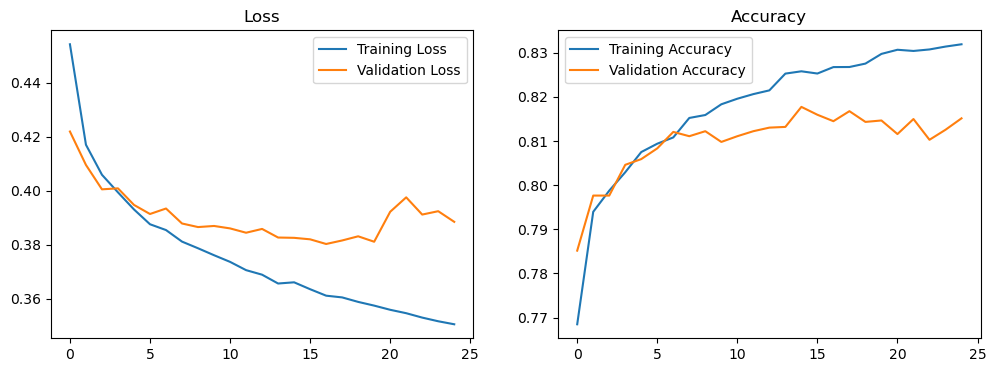

In [62]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      3085
           1       0.85      0.77      0.81      3087

    accuracy                           0.82      6172
   macro avg       0.82      0.82      0.82      6172
weighted avg       0.82      0.82      0.82      6172



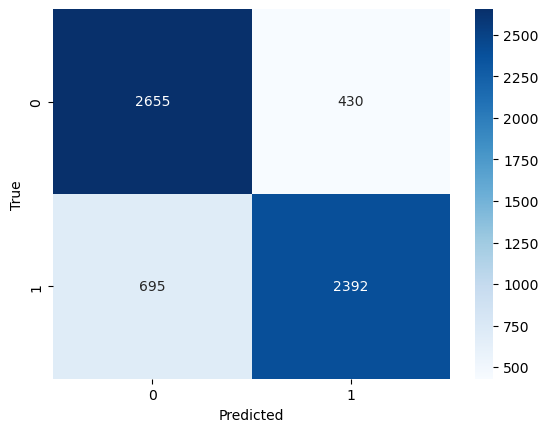

In [63]:
y_predict = modelo.predict(x_test, batch_size=64, verbose=False)
#y_predict_classes = (y_predict > 0.5).astype(int)
y_predict_bool = np.argmax(y_predict, axis=1)

#metricas(y_predict_classes,y_test)
metricas(y_predict_bool,y_test)

### Prediccion Kaggle

In [64]:
if not TESTING: 
    y_predict = modelo.predict(x_predict, verbose=False)
    y_predict_bool = np.argmax(y_predict, axis=1)
    nn_result = pd.DataFrame({'id': ds_test['id'], 'is_canceled': y_predict_bool})
    print(nn_result.head())
    nn_result.to_csv('../predicts/predicts_nn.csv', index=False)

                                     id  is_canceled
0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1
1  aba9aac2-4495-4645-a60e-90328713c999            0
2  b345b5dc-c804-4d77-a39f-1f4e65d1f1ad            0
3  ce1b400e-afa1-4946-bdff-004b859eb61c            1
4  c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214            1
